In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer

2023-06-09 23:41:30.513929: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-09 23:41:30.569818: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-09 23:41:30.570745: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 23:41:31.700049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Chitvan Patel & Allen Shelton

# 1. Introduction

In this lab, you will see the power of word embeddings, and how embeddings can be used in different applications.

Summarize the papers that were distributed with the module.

In [1]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


**Effective Approaches to Attention-based Neural Machine Translation**

The task of Machine Translation (MT) involves understanding natural language and has traditionally been challenging to improve performance. However, the introduction of neural networks in MT has led to significant advancements, surpassing the performance of conventional phrase-based translation.

To enhance the performance of Neural Machine Translation (NMT), the authors utilized additive attention. This was necessary because incorporating all the information from a source sentence into a fixed-length vector, known as a context vector, posed difficulties. To overcome this, the authors employed soft-alignment, which enabled joint learning of alignment and translation.

From a probabilistic standpoint, translation involves finding a target sentence that maximizes the conditional probability given a source sentence. The authors proposed two attention mechanisms: global attention and local attention. The local attention mechanism, which is a novel approach, considers the trade-off between soft and hard attention models proposed by Xu et al. (2015).

NMT has gained popularity due to its state-of-the-art performance in large-scale translation tasks, such as English to French/German. It requires minimal domain knowledge and is conceptually simple. Furthermore, NMT has a smaller memory footprint compared to systems that rely on extensive phrase tables and language models. Additionally, NMT exhibits the ability to handle long word sentences effectively.

In non-attention-based RNN architectures, the source representation S is used only once to initialize the decoder hidden state. In contrast, attention-based networks consider a set of source hidden states S throughout the translation process. Global attention is computationally expensive and less effective for long sentences, while local attention focuses on a subset of hidden states to address this issue.

The input-feeding approach was introduced to ensure that future alignment decisions incorporate past alignment information. This is achieved by concatenating the previous alignment information, represented as h_bar(t), with inputs at subsequent time steps. This approach enables the model to be fully aware of previous alignment choices and facilitates the creation of a deep network that spans horizontally and vertically.

**Attention is all you need**

The paper aims to address the limitations of sequential computation in recurrent neural networks (RNNs), long short-term memory networks (LSTMs), and gated RNNs for sequence modeling tasks like machine translation and language modeling. These approaches process sequences word-by-word in a sequential manner, hindering parallelization and causing issues with long-range dependencies.

To overcome these challenges, attention mechanisms have been proposed. They allow for modeling dependencies without considering their distance in the input or output sequences and have become integral to sequence modeling. However, attention mechanisms are typically used in combination with recurrent networks.

The paper introduces the Transformer model, which relies solely on attention mechanisms to capture global dependencies between inputs and outputs. This architecture enables significantly more parallelization and achieves remarkable translation quality with relatively short training times.

The Transformer follows an encoder-decoder structure, using stacked self-attention and point-wise fully connected layers for both the encoder and decoder. It utilizes scaled dot-product attention and multi-head attention to jointly attend to information from different representation subspaces at different positions.

Compared to recurrent layers, self-attention layers in the Transformer have lower computational complexity per layer and allow for more efficient parallelization. This makes the Transformer faster for machine translation tasks, especially when the sequence length is smaller than the representation dimensionality.

The paper highlights that the Transformer outperforms previous models on English-to-German and English-to-French translation tasks, achieving a new state-of-the-art performance. The authors also express their intention to explore the application of the Transformer in other domains involving different modalities like images, audio, and video.

The Transformer architecture presented in the paper has gained significant attention and popularity, leading to its implementation and adoption in various natural language processing (NLP) tasks. Additionally, an annotated version of the paper, accompanied by PyTorch code, has been released to facilitate understanding and further experimentation with the Transformer model.

**Deep contextualized word representations**

Word representations are crucial in Natural Language Processing (NLP) systems as they enable us to convert text into numerical representations that computers can understand. Over the years, various word representations have been developed to capture the semantics and syntactic dependencies of words. However, creating accurate word representations that account for the complexities of human language is a challenging task.

Good word representations should group similar words together, reflecting their semantic similarities. Additionally, they need to consider language polysemy, where a word can have multiple meanings in different contexts. For example, the word "apple" can refer to a fruit or a technology company. Previous approaches, such as label encoding or one-hot encoding, have limitations in terms of bias and computational efficiency.

To address these issues, Deep Contextualized Word Representations (ELMo) gained attention. ELMo breaks down words into atomic units, capturing insights into word formation. It recognizes that words can have different meanings depending on the context and computes representations by considering the entire sequence as input.

ELMo incorporates Convolutional Neural Networks (CNNs) to extract character-based embeddings and capture n-gram features. These embeddings handle out-of-vocabulary words effectively and provide finer language details. Bi-directional Long Short-Term Memory (LSTM) layers consider input from both past and future contexts, preserving information about the entire sequence.

Unlike previous models, ELMo uses a linear combination of all LSTM hidden states, giving different weights to each layer based on the task at hand. Higher-level layers capture context-dependent aspects of word meaning, while lower-level layers model language syntax. This allows for rich word representations with different properties for various NLP tasks.

Experimental results demonstrate the power of ELMo, surpassing state-of-the-art performance across various NLP problems. ELMo's representations can be easily incorporated into existing architectures, enabling transfer learning and semi-supervised learning. This approach has proven effective in computer vision, and ELMo opens up similar possibilities in language models.

In conclusion, ELMo introduces a general approach to learning high-quality deep context-dependent word representations. It offers the potential for leveraging pre-trained representations and applying them to different NLP tasks, reducing the need for task-specific model training from scratch. The future holds exciting prospects for further advancements in language model transfer learning.

# 2. GloVe

We will first read imdb movie reviews to train a GloVe embeddings.

GloVe is computed from a co-occurrence matrix $X$ as follows:

$
J = \sum_{i=1,j=1}^{V,V} f(X_{ij}) (w_i^T w_j + b_i + b_j - log(X_{ij}))^2
$

$f(X_{ij}) = (X_{ij} / X_{\max})^\alpha$ if $X_{ij} < X_{\max}$; otherwise it is $1$.

$
\nabla_{w_i} J = f(X_{ij}) w_j (w_i^T w_j + b_i + b_j - log(X_{ij}))
$

$
\nabla_{w_j} J = f(X_{ij}) w_i (w_i^T w_j + b_i + b_j - log(X_{ij}))
$

$
\nabla_{b_i} J = \nabla_{b_j} J = f(X_{ij}) (w_i^T w_j + b_i + b_j - log(X_{ij}))
$

In [ ]:
from keras import preprocessing
from keras.datasets import imdb
from random import shuffle

In [ ]:
start_char = 1
oov_char = 2
index_from = 3

(x_train, _), _ = imdb.load_data(
    start_char=start_char, oov_char=oov_char, index_from=index_from
)

word_index = imdb.get_word_index()
inverted_word_index = dict(
    (i + index_from, word) for (word, i) in word_index.items()
)
# Update `inverted_word_index` to include `start_char` and `oov_char`
inverted_word_index[start_char] = "[START]"
inverted_word_index[oov_char] = "[OOV]"
vocab_size = max(word_index.values()) + index_from

decoded_sequence = " ".join(inverted_word_index[i] for i in x_train[0])
decoded_sequence

"[START] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sh

In [ ]:
from tqdm import tqdm
import os

window = 10
left_window = window // 2
right_window = window - left_window

def gen_X():
    if os.path.exists('indexes.npy') and os.path.exists('X.npy'): return
    X = np.zeros((vocab_size, vocab_size), dtype=np.float32)
    indexes = set()
    for s in tqdm(x_train):
        for i in range(len(s)):
            w = s[i]
            j_indexes = np.concatenate([
                np.arange(max(0, i - left_window), i),
                np.arange(i+1, min(len(s), i + right_window + 1))])
            for j in j_indexes:
                d = 1.0 / (j - i)
                c = s[j]
                X[w, c] += d
    indexes = []
    all_idx = np.arange(vocab_size)
    for i in tqdm(range(vocab_size)):
        mask = X[i] != 0
        if np.sum(mask) == 0: continue
        for j in all_idx[mask]:
            indexes.append((i, j))

    indexes = np.array(indexes, dtype=np.int64)

    # generate f function
    np.save('X.npy', X.astype(np.float32))
    np.save('indexes.npy', indexes)

gen_X()

In [ ]:
embedding_size = 50

In [ ]:
import torch

class Glove(torch.nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.W = torch.nn.Embedding(vocab_size, embedding_size)
        self.C = torch.nn.Embedding(vocab_size, embedding_size)
        self.b_w = torch.nn.Embedding(vocab_size, 1)
        self.b_c = torch.nn.Embedding(vocab_size, 1)

    def loss(self, index, Xij, Xmax=1000, alpha=0.75):
        i = index[:, 0]
        j = index[:, 1]

        f = torch.where(Xij < Xmax, torch.pow(Xij / Xmax, alpha), 1)
        loss = f * torch.pow(
            torch.einsum('ij,ij->i', self.W(i), self.C(j)) +
            self.b_w(i) + self.b_c(j) - torch.log10(Xij + 1e-6), 2)

        return loss.mean()

In [ ]:
glove = Glove(vocab_size, embedding_size)

# load but leave vectors in disk
X = np.load('X.npy', mmap_mode='r')
indexes = np.load('indexes.npy', mmap_mode='r')

shuffle_idx = np.arange(len(indexes))
np.random.shuffle(shuffle_idx)

In [ ]:
glove.load_state_dict(torch.load('glove.pth'))

<All keys matched successfully>

In [ ]:
device = 'cuda'

In [ ]:
glove = glove.to(device)

print('... done wth transferring to device')

... done wth transferring to device


In [ ]:
optimizer = torch.optim.Adagrad(glove.parameters(), lr=0.005, weight_decay=0.95)

good = torch.tensor(word_index['good'] + index_from, dtype=torch.int64).to('cuda')
bad = torch.tensor(word_index['bad'] + index_from, dtype=torch.int64).to('cuda')

epochs = 100
batch_size = 8192
Xmax = 1000.0
for epoch in range(epochs):
    print('epoch', epoch)
    np.random.shuffle(shuffle_idx)
    loss_v = []
    for i in tqdm(range(0, len(shuffle_idx), batch_size)):
        index_batch = shuffle_idx[i:i+batch_size]
        index_batch = np.array([indexes[ii] for ii in index_batch])
        X_batch = np.concatenate(
            [[X[ii,jj]] for ii, jj in index_batch ]).astype(np.float32)
        X_batch = np.clip(X_batch, 0.0, Xmax)
        index_batch = torch.from_numpy(np.array(index_batch).astype(np.int64)).to('cuda')
        X_batch = torch.from_numpy(X_batch.astype(np.float32)).to('cuda')
        loss = glove.loss(index_batch, X_batch, Xmax)
        loss_v.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    good_v = glove.W(good).detach().cpu().numpy()
    bad_v = glove.W(bad).detach().cpu().numpy()
    good_v = good_v / np.linalg.norm(good_v)
    bad_v = bad_v / np.linalg.norm(bad_v)

    print(f'... {epoch}: {np.mean(loss_v)} good.bad = {np.dot(good_v, bad_v)}')


epoch 0


100%|██████████| 1405/1405 [02:33<00:00,  9.18it/s]


... 0: 0.06248276188863554 good.bad = -0.03340145945549011
epoch 1


100%|██████████| 1405/1405 [01:36<00:00, 14.61it/s]


... 1: 0.03317142643326118 good.bad = -0.024984167888760567
epoch 2


100%|██████████| 1405/1405 [01:36<00:00, 14.61it/s]


... 2: 0.02259632499285334 good.bad = -0.019734593108296394
epoch 3


100%|██████████| 1405/1405 [01:35<00:00, 14.64it/s]


... 3: 0.016814856449294556 good.bad = -0.016693606972694397
epoch 4


100%|██████████| 1405/1405 [01:36<00:00, 14.57it/s]


... 4: 0.01317681285463194 good.bad = -0.015193117782473564
epoch 5


100%|██████████| 1405/1405 [01:36<00:00, 14.54it/s]


... 5: 0.010713815233368573 good.bad = -0.014707675203680992
epoch 6


100%|██████████| 1405/1405 [01:37<00:00, 14.47it/s]


... 6: 0.008965125818839594 good.bad = -0.014870867133140564
epoch 7


100%|██████████| 1405/1405 [01:35<00:00, 14.69it/s]


... 7: 0.007675514038440066 good.bad = -0.015435706824064255
epoch 8


100%|██████████| 1405/1405 [01:35<00:00, 14.66it/s]


... 8: 0.006705324119785502 good.bad = -0.016230471432209015
epoch 9


100%|██████████| 1405/1405 [01:36<00:00, 14.50it/s]


... 9: 0.0059518910743945755 good.bad = -0.01714819110929966
epoch 10


100%|██████████| 1405/1405 [01:36<00:00, 14.57it/s]


... 10: 0.005358907364116604 good.bad = -0.018106093630194664
epoch 11


100%|██████████| 1405/1405 [01:36<00:00, 14.60it/s]


... 11: 0.004886389062889053 good.bad = -0.0190516896545887
epoch 12


100%|██████████| 1405/1405 [01:35<00:00, 14.71it/s]


... 12: 0.004506001805263535 good.bad = -0.019947195425629616
epoch 13


100%|██████████| 1405/1405 [01:36<00:00, 14.51it/s]


... 13: 0.004192515127393964 good.bad = -0.020767763257026672
epoch 14


100%|██████████| 1405/1405 [01:35<00:00, 14.78it/s]


... 14: 0.003935289593559302 good.bad = -0.02149774506688118
epoch 15


100%|██████████| 1405/1405 [01:35<00:00, 14.66it/s]


... 15: 0.0037211891508982698 good.bad = -0.022129258140921593
epoch 16


100%|██████████| 1405/1405 [01:35<00:00, 14.71it/s]


... 16: 0.00354880151451562 good.bad = -0.02265794388949871
epoch 17


100%|██████████| 1405/1405 [01:36<00:00, 14.51it/s]


... 17: 0.0033935965560840647 good.bad = -0.023084860295057297
epoch 18


100%|██████████| 1405/1405 [01:36<00:00, 14.57it/s]


... 18: 0.0032625092655831278 good.bad = -0.023411406204104424
epoch 19


100%|██████████| 1405/1405 [01:36<00:00, 14.60it/s]


... 19: 0.0031515206024713576 good.bad = -0.02364262193441391
epoch 20


100%|██████████| 1405/1405 [01:36<00:00, 14.63it/s]


... 20: 0.003058399775254398 good.bad = -0.023783963173627853
epoch 21


100%|██████████| 1405/1405 [01:37<00:00, 14.48it/s]


... 21: 0.0029800133399327296 good.bad = -0.02384157106280327
epoch 22


100%|██████████| 1405/1405 [01:36<00:00, 14.54it/s]


... 22: 0.00290548521039338 good.bad = -0.023821726441383362
epoch 23


100%|██████████| 1405/1405 [01:36<00:00, 14.58it/s]


... 23: 0.002846150808831763 good.bad = -0.023731477558612823
epoch 24


100%|██████████| 1405/1405 [01:36<00:00, 14.59it/s]


... 24: 0.002789799406257826 good.bad = -0.023576965555548668
epoch 25


100%|██████████| 1405/1405 [01:35<00:00, 14.66it/s]


... 25: 0.002743588176844277 good.bad = -0.02336505986750126
epoch 26


100%|██████████| 1405/1405 [01:35<00:00, 14.66it/s]


... 26: 0.002701136177435544 good.bad = -0.02310149185359478
epoch 27


100%|██████████| 1405/1405 [01:36<00:00, 14.58it/s]


... 27: 0.002670788661215547 good.bad = -0.022792331874370575
epoch 28


100%|██████████| 1405/1405 [01:35<00:00, 14.66it/s]


... 28: 0.0026328542877114593 good.bad = -0.02244432456791401
epoch 29


100%|██████████| 1405/1405 [01:36<00:00, 14.49it/s]


... 29: 0.0026045046213954634 good.bad = -0.022059030830860138
epoch 30


100%|██████████| 1405/1405 [01:36<00:00, 14.58it/s]


... 30: 0.0025779960065536547 good.bad = -0.02164446748793125
epoch 31


100%|██████████| 1405/1405 [01:36<00:00, 14.62it/s]


... 31: 0.002554772372251489 good.bad = -0.021204203367233276
epoch 32


100%|██████████| 1405/1405 [01:36<00:00, 14.56it/s]


... 32: 0.0025331759622347046 good.bad = -0.02074250392615795
epoch 33


100%|██████████| 1405/1405 [01:35<00:00, 14.66it/s]


... 33: 0.0025143549287048733 good.bad = -0.020263075828552246
epoch 34


100%|██████████| 1405/1405 [01:35<00:00, 14.66it/s]


... 34: 0.0024983906591463556 good.bad = -0.019768062978982925
epoch 35


100%|██████████| 1405/1405 [01:35<00:00, 14.67it/s]


... 35: 0.002484748463496049 good.bad = -0.019261859357357025
epoch 36


100%|██████████| 1405/1405 [01:36<00:00, 14.60it/s]


... 36: 0.0024703890957713816 good.bad = -0.018747352063655853
epoch 37


100%|██████████| 1405/1405 [01:36<00:00, 14.61it/s]


... 37: 0.0024594494773843905 good.bad = -0.01822620816528797
epoch 38


100%|██████████| 1405/1405 [01:35<00:00, 14.77it/s]


... 38: 0.002445270789843517 good.bad = -0.017701920121908188
epoch 39


100%|██████████| 1405/1405 [01:35<00:00, 14.64it/s]


... 39: 0.0024365651301933564 good.bad = -0.017176667228341103
epoch 40


100%|██████████| 1405/1405 [01:36<00:00, 14.61it/s]


... 40: 0.002425451380378 good.bad = -0.016650931909680367
epoch 41


100%|██████████| 1405/1405 [01:36<00:00, 14.57it/s]


... 41: 0.002417023250629323 good.bad = -0.01612660475075245
epoch 42


100%|██████████| 1405/1405 [01:37<00:00, 14.46it/s]


... 42: 0.0024096596174876727 good.bad = -0.015606082044541836
epoch 43


100%|██████████| 1405/1405 [01:37<00:00, 14.48it/s]


... 43: 0.002402121242006505 good.bad = -0.01509122084826231
epoch 44


100%|██████████| 1405/1405 [01:36<00:00, 14.54it/s]


... 44: 0.00239915789077655 good.bad = -0.014580445364117622
epoch 45


100%|██████████| 1405/1405 [01:35<00:00, 14.67it/s]


... 45: 0.0023900524178251384 good.bad = -0.014077920466661453
epoch 46


100%|██████████| 1405/1405 [01:35<00:00, 14.73it/s]


... 46: 0.0023852556617847674 good.bad = -0.013583346270024776
epoch 47


100%|██████████| 1405/1405 [01:35<00:00, 14.69it/s]


... 47: 0.0023798566462399167 good.bad = -0.013097896240651608
epoch 48


100%|██████████| 1405/1405 [01:35<00:00, 14.68it/s]


... 48: 0.0023737788460137872 good.bad = -0.012620002031326294
epoch 49


100%|██████████| 1405/1405 [01:36<00:00, 14.62it/s]


... 49: 0.002374002364135987 good.bad = -0.012153136543929577
epoch 50


100%|██████████| 1405/1405 [01:35<00:00, 14.72it/s]


... 50: 0.0023657625007900505 good.bad = -0.01169655378907919
epoch 51


100%|██████████| 1405/1405 [01:35<00:00, 14.72it/s]


... 51: 0.0023615060749486937 good.bad = -0.011250740848481655
epoch 52


100%|██████████| 1405/1405 [01:35<00:00, 14.67it/s]


... 52: 0.0023597445945898435 good.bad = -0.01081642135977745
epoch 53


100%|██████████| 1405/1405 [01:35<00:00, 14.70it/s]


... 53: 0.002354899912432923 good.bad = -0.010392813012003899
epoch 54


100%|██████████| 1405/1405 [01:34<00:00, 14.81it/s]


... 54: 0.002354936657789962 good.bad = -0.009982115589082241
epoch 55


100%|██████████| 1405/1405 [01:35<00:00, 14.69it/s]


... 55: 0.0023487493633193184 good.bad = -0.009580831974744797
epoch 56


100%|██████████| 1405/1405 [01:35<00:00, 14.70it/s]


... 56: 0.0023462268027553196 good.bad = -0.00919290166348219
epoch 57


100%|██████████| 1405/1405 [01:35<00:00, 14.70it/s]


... 57: 0.0023436834794979583 good.bad = -0.008815707638859749
epoch 58


100%|██████████| 1405/1405 [01:35<00:00, 14.77it/s]


... 58: 0.0023412997855098913 good.bad = -0.008450955152511597
epoch 59


100%|██████████| 1405/1405 [01:35<00:00, 14.66it/s]


... 59: 0.0023392193291992534 good.bad = -0.00809763465076685
epoch 60


100%|██████████| 1405/1405 [01:35<00:00, 14.69it/s]


... 60: 0.002337520486497887 good.bad = -0.007756185717880726
epoch 61


100%|██████████| 1405/1405 [01:36<00:00, 14.53it/s]


... 61: 0.0023380232371267235 good.bad = -0.007426075171679258
epoch 62


100%|██████████| 1405/1405 [01:37<00:00, 14.44it/s]


... 62: 0.002333400629832015 good.bad = -0.007107153069227934
epoch 63


100%|██████████| 1405/1405 [01:36<00:00, 14.64it/s]


... 63: 0.0023316660809357156 good.bad = -0.006799257360398769
epoch 64


100%|██████████| 1405/1405 [01:36<00:00, 14.53it/s]


... 64: 0.002329948551358748 good.bad = -0.006502607371658087
epoch 65


100%|██████████| 1405/1405 [01:37<00:00, 14.48it/s]


... 65: 0.002331054501825433 good.bad = -0.006216910667717457
epoch 66


100%|██████████| 1405/1405 [01:36<00:00, 14.63it/s]


... 66: 0.002328756836067315 good.bad = -0.005972929298877716
epoch 67


100%|██████████| 1405/1405 [01:36<00:00, 14.60it/s]


... 67: 0.002326344055938949 good.bad = -0.0056764367036521435
epoch 68


100%|██████████| 1405/1405 [01:35<00:00, 14.65it/s]


... 68: 0.0023294759312730774 good.bad = -0.005421353038400412
epoch 69


100%|██████████| 1405/1405 [01:35<00:00, 14.66it/s]


... 69: 0.0023237707596305375 good.bad = -0.005176565144211054
epoch 70


100%|██████████| 1405/1405 [01:36<00:00, 14.57it/s]


... 70: 0.002325895865981424 good.bad = -0.004941058345139027
epoch 71


100%|██████████| 1405/1405 [01:35<00:00, 14.72it/s]


... 71: 0.0023213513086556567 good.bad = -0.00471485685557127
epoch 72


100%|██████████| 1405/1405 [01:35<00:00, 14.65it/s]


... 72: 0.0023220601384743413 good.bad = -0.00449789222329855
epoch 73


100%|██████████| 1405/1405 [01:36<00:00, 14.60it/s]


... 73: 0.0023232495284629356 good.bad = -0.004289791453629732
epoch 74


100%|██████████| 1405/1405 [01:36<00:00, 14.49it/s]


... 74: 0.0023183781322211132 good.bad = -0.004090576432645321
epoch 75


100%|██████████| 1405/1405 [01:36<00:00, 14.59it/s]


... 75: 0.0023183026508878904 good.bad = -0.0038987495936453342
epoch 76


100%|██████████| 1405/1405 [01:35<00:00, 14.67it/s]


... 76: 0.0023216753356652565 good.bad = -0.0037153454031795263
epoch 77


100%|██████████| 1405/1405 [01:36<00:00, 14.62it/s]


... 77: 0.0023159891868663085 good.bad = -0.003539860248565674
epoch 78


100%|██████████| 1405/1405 [01:36<00:00, 14.59it/s]


... 78: 0.002316918812677251 good.bad = -0.003371940925717354
epoch 79


100%|██████████| 1405/1405 [01:35<00:00, 14.68it/s]


... 79: 0.002314940580122133 good.bad = -0.0032112221233546734
epoch 80


100%|██████████| 1405/1405 [01:36<00:00, 14.61it/s]


... 80: 0.0023168411248386755 good.bad = -0.003057246096432209
epoch 81


100%|██████████| 1405/1405 [01:35<00:00, 14.64it/s]


... 81: 0.0023144929168092956 good.bad = -0.002910197712481022
epoch 82


100%|██████████| 1405/1405 [01:36<00:00, 14.61it/s]


... 82: 0.002313349203470087 good.bad = -0.0027696702163666487
epoch 83


100%|██████████| 1405/1405 [01:36<00:00, 14.58it/s]


... 83: 0.0023154124236016062 good.bad = -0.002635475480929017
epoch 84


100%|██████████| 1405/1405 [01:36<00:00, 14.57it/s]


... 84: 0.0023127273888844213 good.bad = -0.002507021650671959
epoch 85


100%|██████████| 1405/1405 [01:35<00:00, 14.70it/s]


... 85: 0.0023109349874560836 good.bad = -0.002385345520451665
epoch 86


100%|██████████| 1405/1405 [01:35<00:00, 14.64it/s]


... 86: 0.0023110343689791645 good.bad = -0.002267694566398859
epoch 87


100%|██████████| 1405/1405 [01:36<00:00, 14.52it/s]


... 87: 0.0023111563118744733 good.bad = -0.00215611862950027
epoch 88


100%|██████████| 1405/1405 [01:36<00:00, 14.50it/s]


... 88: 0.0023096024057516346 good.bad = -0.0020496349316090345
epoch 89


100%|██████████| 1405/1405 [01:36<00:00, 14.63it/s]


... 89: 0.0023094096450960375 good.bad = -0.0019481094786897302
epoch 90


100%|██████████| 1405/1405 [01:36<00:00, 14.62it/s]


... 90: 0.0023086791465123553 good.bad = -0.0018512142123654485
epoch 91


100%|██████████| 1405/1405 [01:36<00:00, 14.51it/s]


... 91: 0.0023095542325528864 good.bad = -0.0017658504657447338
epoch 92


100%|██████████| 1405/1405 [01:35<00:00, 14.64it/s]


... 92: 0.0023137365322430815 good.bad = -0.0016709745395928621
epoch 93


100%|██████████| 1405/1405 [01:37<00:00, 14.45it/s]


... 93: 0.002307774529260421 good.bad = -0.0015874382806941867
epoch 94


100%|██████████| 1405/1405 [01:36<00:00, 14.53it/s]


... 94: 0.0023074586391018115 good.bad = -0.001507174107246101
epoch 95


100%|██████████| 1405/1405 [01:36<00:00, 14.58it/s]


... 95: 0.0023080542326898205 good.bad = -0.0014313148567453027
epoch 96


100%|██████████| 1405/1405 [01:36<00:00, 14.60it/s]


... 96: 0.0023077587320326806 good.bad = -0.0013589588925242424
epoch 97


100%|██████████| 1405/1405 [01:35<00:00, 14.70it/s]


... 97: 0.002306541762964343 good.bad = -0.0012901582522317767
epoch 98


100%|██████████| 1405/1405 [01:35<00:00, 14.75it/s]


... 98: 0.0023127468219988076 good.bad = -0.0012249466963112354
epoch 99


100%|██████████| 1405/1405 [01:36<00:00, 14.53it/s]

... 99: 0.0023090753530307915 good.bad = -0.001161817810498178


In [ ]:
torch.save(glove.state_dict(), 'glove.pth')

In [ ]:
good = torch.tensor(word_index['good'] + index_from, dtype=torch.int64).to('cuda')
bad = torch.tensor(word_index['bad'] + index_from, dtype=torch.int64).to('cuda')

good_v = glove.W(good).detach().cpu().numpy()
bad_v = glove.W(bad).detach().cpu().numpy()
good_v = good_v / np.linalg.norm(good_v)
bad_v = bad_v / np.linalg.norm(bad_v)

np.dot(good_v, bad_v)

-0.0011618178

In [ ]:
positive = torch.tensor(word_index['positive'] + index_from, dtype=torch.int64)
positive_v = glove.W(positive).detach().cpu().numpy()

synonym = ('',0)
antonym = ('',1)
for word in word_index.values():
    if inverted_word_index[word + index_from] != 'positive':
        word_v = glove.W(torch.tensor(word, dtype=torch.int64)).detach().cpu().numpy()
        similarity = np.dot(word_v, positive_v)
        if similarity > synonym[1]:
            synonym = (inverted_word_index[word + index_from],similarity)
        if similarity < antonym[1]:
            antonym = (inverted_word_index[word + index_from],similarity)

print(f"Synonym for positive: {synonym[0]}  Dot product: {synonym[1]}")
print(f"Antonym for positive: {antonym[0]}  Dot product: {antonym[1]}")

Synonym for positive: buoy  Dot product: 0.23424024879932404
Antonym for positive: worzel  Dot product: -0.21876290440559387


Now explain with your own words how Glove works.  Find which word is a synonym for `positive` and an antonym for `positive`.

In [ ]:
# your code goes here

that -0.8571522583437434
deal 0.8781584108127223


# 3. Second Attempt to Build a Large Language Model

In an attempt to create our first generator network before we start using transformers, you will build a large language model using a Convolutional (causal) and Embeddings.

We will split this task into two task.

- First task is to try to predict the next word.
- Second task is to implement and train a network that will use the head to predict the sentiment of the sentence.

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import string
import os
import pandas as pd
import numpy as np

In [ ]:
class Tokenizer:
    def __init__(self):
        self.chars = ['\00', '\01'] + sorted(list(set(string.printable)))
        self.vocab_size = len(self.chars)
        self.stoi = { ch:i for i,ch in enumerate(self.chars) }
        self.itos = { i:ch for i,ch in enumerate(self.chars) }

        self.itos[0] = '[START]'
        self.itos[1] = '[OOV]'

    def encode(self, sentence):
        return [self.stoi[c] if c in self.stoi else 1 for c in sentence]

    def decode(self, indexes):
        return [self.itos[i] for i in indexes]

    def start(self): return '\00'

    def oov(self): return '\01'

tokenizer = Tokenizer()
print(tokenizer.encode('hello world'))
print(tokenizer.decode([0] + [1] + tokenizer.encode('\x96hello world')))

[79, 76, 83, 83, 86, 7, 94, 86, 89, 83, 75]
['[START]', '[OOV]', '[OOV]', 'h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd']


In [ ]:
def process_songs(df):
    songs = tokenizer.start().join(df.text.to_numpy())
    songs = tokenizer.start() + songs.replace('\r', '', -1)
    return tokenizer.encode(songs)

In [ ]:
# Download the song dataset from
# https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset

In [ ]:
df = pd.read_csv('spotify_millsongdata.csv')
print(len(df), 'songs')

57650 songs


In [ ]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [ ]:
if not os.path.exists('spotify_x_train.bin') or not os.path.exists('spotify_x_test.bin'):
    train_size = int(len(df) * 0.9)
    x_train = process_songs(df.iloc[:train_size])
    x_test = process_songs(df.iloc[train_size:])
    assert np.max(x_train) < 256
    print(len(x_train), len(x_test))

    x_train = np.array(x_train, dtype=np.uint8)
    x_test = np.array(x_test, dtype=np.uint8)

    x_train.tofile('spotify_x_train.bin')
    x_test.tofile('spotify_x_test.bin')

In [ ]:
# we will use mmap to reduce memory in this jupyter notebook
x_train = np.memmap('spotify_x_train.bin', dtype=np.uint8, mode='r')
x_test = np.memmap('spotify_x_test.bin', dtype=np.uint8, mode='r')

In [ ]:
x_train.shape

(61025756,)

In [ ]:
df.text.apply(len).min(), df.text.apply(len).max()

(410, 4186)

In [ ]:
len(df.artist.unique())

643

In [ ]:
# this code is derived from nanogpt (https://github.com/karpathy/nanoGPT)

class CausalSelfAttention(nn.Module):
    def __init__(self, transformers_size, n_heads, dropout,
                 max_seqlen, bias):
        super().__init__()
        assert transformers_size % n_heads == 0
        self.c_attn = nn.Linear(
                transformers_size, 3 * transformers_size, bias=bias)
        # output projection
        self.c_proj = nn.Linear(transformers_size,
                                transformers_size, bias=bias)
        # regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
        self.n_heads = n_heads
        self.transformers_size = transformers_size
        self.dropout = dropout

        self.register_buffer(
            "bias", torch.tril(torch.ones(max_seqlen, max_seqlen))
            .view(1, 1, max_seqlen, max_seqlen))

    def forward(self, x):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch
        # and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.transformers_size, dim=2)
        # (B, nh, T, hs)
        k = k.view(B, T, self.n_heads, C // self.n_heads).transpose(1, 2)
        q = q.view(B, T, self.n_heads, C // self.n_heads).transpose(1, 2)
        v = v.view(B, T, self.n_heads, C // self.n_heads).transpose(1, 2)

        # causal self-attention; Self-attend:
        #     (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        # manual implementation of attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        # re-assemble all head outputs side by side
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class FeedForward(nn.Module):
    def __init__(self, transformers_size, dropout, bias=False):
        super().__init__()
        n = 4
        self.c_fc    = nn.Linear(
            transformers_size, n * transformers_size, bias=bias)
        self.c_proj  = nn.Linear(
            n * transformers_size, transformers_size, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = nn.GELU(approximate='tanh')(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(
            self, transformers_size, num_heads, dropout,
            max_seqlen, bias=False):
        super().__init__()
        self.ln_1 = nn.LayerNorm(transformers_size)
        self.attn = CausalSelfAttention(
            transformers_size, num_heads, dropout, max_seqlen, bias=bias)
        self.ln_2 = nn.LayerNorm(transformers_size)
        self.mlp = FeedForward(transformers_size, dropout, bias)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

class LLM(nn.Module):
    def __init__(self, n_layers, num_heads, embedding_size, vocab_size, max_seqlen, dropout):
        super().__init__()
        self.max_seqlen = max_seqlen
        self.wte = nn.Embedding(vocab_size, embedding_size)
        self.wpe = nn.Embedding(max_seqlen, embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([
            Block(embedding_size, num_heads, dropout, max_seqlen, bias=True)
            for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(embedding_size)
        self.lm_head = nn.Linear(
            embedding_size, vocab_size, bias=False)

        # from GPT2 / nanoGPT

        self.wte.weight = self.lm_head.weight
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(
                    p, mean=0.0, std=0.02/math.sqrt(2 * n_layers))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        """
        This long function is unfortunately doing something very simple
        and is being very defensive:
        We are separating out all parameters of the model into two buckets:
        those that will experience weight decay for regularization and those
        that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't
        # experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, torch.nn.Conv1d)
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
                # random note: because named_modules and named_parameters
                # are recursive we will see the same tensors p many many
                # times. but doing it this way allows us to know which
                # parent module any tensor p belongs to...
                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif (
                    pn.endswith('weight') and
                    isinstance(m, whitelist_weight_modules)):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif (
                    pn.endswith('weight') and
                    isinstance(m, blacklist_weight_modules)):

                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # subtle: 'transformer.wte.weight' and 'lm_head.weight' are tied,
        # so they will appear in the no_decay and decay sets respectively
        # after the above.
        # In addition, because named_parameters() doesn't return duplicates,
        # it will only return the first occurence, key'd by
        # 'transformer.wte.weight', below. so let's manually remove
        # 'lm_head.weight' from decay set. This will include
        # this tensor into optimization via transformer.wte.weight only,
        # and not decayed.
        decay.remove('lm_head.weight')

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, (
            f"parameters {str(inter_params)} made into " +
            "both decay/no_decay sets!")
        assert len(param_dict.keys() - union_params) == 0, (
            f"parameters {str(param_dict.keys() - union_params)} were not " +
            "separated into either decay/no_decay set!")

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))],
             "weight_decay": weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))],
             "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(
            optim_groups, lr=learning_rate, betas=betas)

        return optimizer

    def forward(self, idx, targets=None, only_head=False):
        device = idx.device
        B, T = idx.shape

        assert T <= self.max_seqlen

        tok_emb = self.wte(idx) # (B, T, C)

        B, T, C = tok_emb.shape

        pos = torch.arange(
            0, T, dtype=torch.long, device=device).unsqueeze(0)
        pos_emb = self.wpe(pos)
        x = self.dropout(tok_emb + pos_emb)
        for block in self.blocks:
            x = block(x)

        if only_head:
            return x

        if targets is not None:
            logits = self.lm_head(x)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None

        return logits, loss

In [ ]:
max_seqlen = 1024
emb_size = 240
n_layers = 6
num_heads = 6
vocab_size = tokenizer.vocab_size
vocab_size

102

In [ ]:
import math
device = 'cuda'

model = LLM(n_layers=n_layers, num_heads=num_heads, embedding_size=emb_size,
            vocab_size=vocab_size, max_seqlen=max_seqlen,
            dropout=0.2)

model = model.to(device)

n_params = sum(p.numel() for n, p in model.named_parameters() if p.requires_grad)
f'{n_params // 1000}K parameters (including embeddings)'

'4436K parameters (including embeddings)'

In [ ]:
batch_size = 32

loss_f = F.cross_entropy

def get_batch(data):
    ix = torch.randint(len(data) - max_seqlen, (batch_size,))
    x = torch.stack([
        torch.from_numpy(data[i:i+max_seqlen].astype(np.int64)) for i in ix])
    y = torch.stack([
        torch.from_numpy(data[i+1:i+max_seqlen+1].astype(np.int64)) for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss(x_train, x_test, eval_iters=100):
    def _internal(model):
        dataset = {'train': x_train, 'val': x_test}
        out = {}
        model.eval()
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(dataset[split])
                p, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
        model.train()
        return out
    return _internal


In [ ]:
x1, y1 = get_batch(x_train)
x1[0][:10], y1[0][:10]

(tensor([84, 80, 85, 75,  7, 84, 76,  7, 86, 77], device='cuda:0'),
 tensor([80, 85, 75,  7, 84, 76,  7, 86, 77,  7], device='cuda:0'))

In [ ]:
import math

def get_lr_func(warmup_iters, learning_rate, lr_decay_iters,  min_lr):
    def __get_lr__(it):
        nonlocal decay_ratio
        # 1) linear warmup for warmup_iters steps
        if it < warmup_iters:
            return learning_rate * it / warmup_iters
        # 2) if it > lr_decay_iters, return min learning rate
        if it > lr_decay_iters:
            return min_lr
        # 3) in between, use cosine decay down to min learning rate
        decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
        assert 0 <= decay_ratio <= 1
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
        return min_lr + coeff * (learning_rate - min_lr)

    decay_ratio = 0
    return __get_lr__

learning_rate = 0.002
get_lr = get_lr_func(1000, learning_rate, 100000, learning_rate/10)

In [ ]:
iter_num = 0
logs = []

In [ ]:
epochs = 7000

estimate_loss_f = estimate_loss(x_train, x_test, eval_iters=100)

optimizer = model.configure_optimizers(
    weight_decay=1e-1, learning_rate=learning_rate, betas=(0.9, 0.95), device_type=device)

for iter_num in range(iter_num, iter_num + epochs):
    learning_rate = get_lr(iter_num)
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

    if iter_num % 100 == 0:
        losses = estimate_loss_f(model)
        print(
            f'step {iter_num}: train loss {losses["train"]:.4f}, '
            f'val loss {losses["val"]:.4f}')
        logs.append((iter_num, losses['train'], losses['val']))

    xb, yb = get_batch(x_train)
    pb, loss = model(xb, yb)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


step 0: train loss 4.6200, val loss 4.6201
step 100: train loss 2.6529, val loss 2.6510
step 200: train loss 2.4043, val loss 2.4106
step 300: train loss 2.3772, val loss 2.3864
step 400: train loss 2.3744, val loss 2.3832
step 500: train loss 2.3586, val loss 2.3644
step 600: train loss 2.3430, val loss 2.3492
step 700: train loss 2.2407, val loss 2.2479
step 800: train loss 1.8395, val loss 1.8504
step 900: train loss 1.6825, val loss 1.6958
step 1000: train loss 1.5341, val loss 1.5571
step 1100: train loss 1.4353, val loss 1.4656
step 1200: train loss 1.3367, val loss 1.3732
step 1300: train loss 1.2721, val loss 1.3113
step 1400: train loss 1.2036, val loss 1.2295
step 1500: train loss 1.1566, val loss 1.1858
step 1600: train loss 1.1174, val loss 1.1465
step 1700: train loss 1.0894, val loss 1.1184
step 1800: train loss 1.0783, val loss 1.1088
step 1900: train loss 1.0500, val loss 1.0810
step 2000: train loss 1.0507, val loss 1.0809
step 2100: train loss 1.0372, val loss 1.0660


In [ ]:
torch.save(model.state_dict(), 'model.pth')

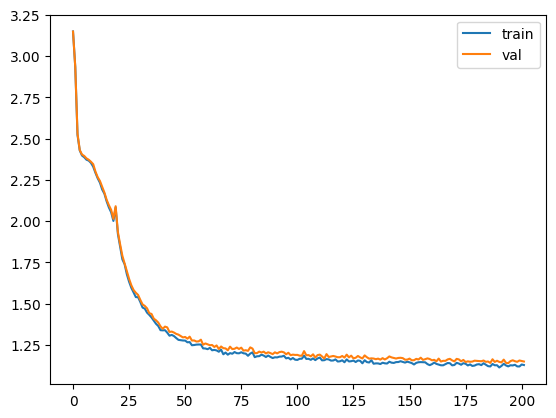

In [ ]:
plt.plot([v[1] for v in logs][1:], label='train')
plt.plot([v[2] for v in logs][1:], label='val')
plt.legend()
plt.show()

In [ ]:
x_test[0:20]

memmap([ 0, 48, 14, 84,  7, 85, 86, 91,  7, 90, 91, 86, 85, 76, 75,  7,
        73, 92, 91,  7], dtype=uint8)

In [ ]:
print(''.join(tokenizer.decode(x_test[0:20])))

[START]I'm not stoned but 


In [ ]:
@torch.no_grad()
def generate(idx, max_new_tokens, top_k=None):
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= max_seqlen else idx[:, -max_seqlen:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        if idx_next == 0: break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [ ]:
idx = torch.from_numpy(np.array([x_test[0:20]]).astype(np.int64))
result = generate(idx.to(device), max_new_tokens=1024, top_k=10).detach().cpu().numpy()
result

array([[ 0, 48, 14, 84,  7, 85, 86, 91,  7, 90, 91, 86, 85, 76, 75,  7,
        73, 92, 91,  7, 48, 14, 84,  7, 85, 86, 91,  7, 91, 86,  7, 83,
        72, 91, 76,  7,  7,  3, 48,  7, 83, 86, 93, 76,  7, 80, 91,  7,
         7,  3, 41, 92, 91,  7, 48, 14, 83, 83,  7, 85, 76, 93, 76, 89,
         7, 96, 76, 84, 19,  7, 73, 72, 73, 96,  7,  7,  3,  7,  7,  3,
        48,  7, 94, 72, 85, 85, 72,  7, 90, 94, 86, 89, 83, 75,  7, 94,
        72, 85, 91,  7, 91, 86,  7, 91, 79, 76,  7, 91, 86,  7, 75, 72,
        85, 74, 76,  7,  7,  3, 53, 86, 91, 79, 80, 85, 14,  7, 91, 89,
        92, 76,  7, 96, 86, 92,  7, 82, 85, 76, 94,  7,  7,  3,  7,  7,
         3, 64, 86, 92, 19,  7, 48, 14, 84,  7, 85, 86, 91,  7, 74, 89,
        92, 87, 91, 80, 85, 14,  7, 84, 96,  7, 83, 80, 77, 76,  7,  7,
         3, 41, 92, 91,  7, 48, 14, 84,  7, 85, 86, 91,  7, 90, 91, 72,
        91, 91, 76, 89,  7,  7,  3, 59, 79, 72, 91,  7, 48,  7, 83, 86,
        93, 76,  7, 80, 91, 14, 90,  7, 78, 86, 80, 85, 14,  7, 

In [ ]:
decoded_sequence = ''.join(tokenizer.decode(result[0]))
print(decoded_sequence)

[START]I'm not stoned but I'm not to late  
I love it  
But I'll never yem, baby  
  
I wanna sworld want to the to dance  
Nothin' true you knew  
  
You, I'm not cruptin' my life  
But I'm not statter  
That I love it's goin' as taker  
  
Not standed but I want to stay  
But you need as I live  
Your show me to know  
  
I know baby to gotta stake  
  
Insantane  
'chumper week on the line  
One to go,  
The love it's wantin'  
I love it it is teed your showd on  
'caupifalls  
To thing I've been but to got to be?  
It's gon' to dank on thring  
To teet your showlet you wonderfucking?  
I knot to be it's right  
  
I will have a fuges for the terror wains  
It's gotta stander waiting?  
I wanted you all doubout  
  
Something's sho went and ton  
He talk and the night  
Aheow  
She won't wait a stars  
I want and thing  
Oh, ahhhnnight's thing  
  
If I shear you all melody  
That I should say the stop or all be and things  
And the night  
I wanted




## Predicting Artist

In [ ]:
import pandas as pd
df = pd.read_csv('spotify_millsongdata.csv')
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [ ]:
ys = list(set(df.artist))
num_labels = len(ys)
y_train = torch.empty(len(df.artist), dtype=torch.int)

for i, artist in enumerate(df.artist):
    y_train[i] = ys.index(artist)

y_train[30000:30100]

tensor([522, 522, 522, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591,
        591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591,
        591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 393, 393, 393, 393,
        393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393,
        393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393,
        393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393,
        125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125,
        125, 125], dtype=torch.int32)

In [ ]:
x_train = df.text
for index, song in enumerate(x_train):
    x_train[index] = tokenizer.encode(song)

print(x_train[:10])
x_train = x_train.to_numpy()

0    [51, 86, 86, 82, 7, 72, 91, 7, 79, 76, 89, 7, ...
1    [59, 72, 82, 76, 7, 80, 91, 7, 76, 72, 90, 96,...
2    [48, 14, 83, 83, 7, 85, 76, 93, 76, 89, 7, 82,...
3    [52, 72, 82, 80, 85, 78, 7, 90, 86, 84, 76, 73...
4    [52, 72, 82, 80, 85, 78, 7, 90, 86, 84, 76, 73...
5    [62, 76, 83, 83, 19, 7, 96, 86, 92, 7, 79, 86,...
6    [43, 86, 94, 85, 7, 80, 85, 7, 91, 79, 76, 7, ...
7    [42, 79, 80, 88, 92, 80, 91, 80, 91, 72, 19, 7...
8    [48, 7, 94, 72, 90, 7, 86, 92, 91, 7, 94, 80, ...
9    [48, 14, 84, 7, 94, 72, 80, 91, 80, 85, 14, 7,...
Name: text, dtype: object


In [ ]:
lens = [len(song) for song in x_train]
print(max(lens))
print(min(lens))

4186
410


In [ ]:
maxlen = 1024
x_train_pad = torch.empty((len(x_train),maxlen), dtype=torch.int)
for i,x in enumerate(x_train):
    if len(x) < maxlen:
        x_train_pad[i] = torch.tensor(x_train[i] + ([0]*(maxlen-len(x))))
    elif len(x) > maxlen:
        x_train_pad[i] = torch.tensor(x_train[i][:maxlen])
    else:
        continue

In [ ]:
lens = [len(song) for song in x_train_pad]
print(max(lens))
print(min(lens))

1024
1024


In [ ]:
class ArtistPredictor(nn.Module):
    def __init__(self, embedding_size, output_size):
        super().__init__()
        self.conv_0 = nn.Conv2d(in_channels = 1,
            out_channels = 16,
            kernel_size = (3, embedding_size))
        self.linear1 = nn.Linear(16*1022, 1000)
        self.linear2 = nn.Linear(1000, output_size)

    def forward(self, x):
        out = x.unsqueeze(1)
        out = F.relu(self.conv_0(out).squeeze(3))
        out = out.flatten(start_dim=1)
        out = F.relu(self.linear1(out))
        out = nn.Sigmoid()(self.linear2(out))
        return out

In [ ]:
indices = torch.randint(len(x_train_pad), (len(x_train_pad),))

x_test = x_train_pad[indices[round(0.8*len(indices)):]]
x_train = x_train_pad[indices[:round(0.8*len(indices))]]
y_test = y_train[indices[round(0.8*len(indices)):]]
y_train = y_train[indices[:round(0.8*len(indices))]]

print(len(x_train),len(x_test),len(y_train),len(y_test))

46120 11530 46120 11530


In [ ]:
max_seqlen = 1024
emb_size = 240
n_layers = 6
num_heads = 6
vocab_size = tokenizer.vocab_size
vocab_size

102

In [ ]:
import math

device = 'cuda'
head = LLM(n_layers=n_layers, num_heads=num_heads, embedding_size=emb_size,
            vocab_size=vocab_size, max_seqlen=max_seqlen,
            dropout=0.2)

head.load_state_dict(torch.load('model.pth'))
head = head.to(device)
head.eval()

n_params = sum(p.numel() for n, p in head.named_parameters() if p.requires_grad)
f'{n_params // 1000}K parameters (including embeddings)'

'4436K parameters (including embeddings)'

In [ ]:
from tqdm import tqdm
#batch_size = 32

artist_model = ArtistPredictor(emb_size, num_labels)
artist_model = artist_model.to(device)

artist_optimizer = torch.optim.Adam(artist_model.parameters(), lr=0.001)
artist_loss_f = nn.CrossEntropyLoss()

for epoch in range(12):
    artist_model.train()
    train_loss = 0
    for i in tqdm(range(len(x_train))):
        xb = x_train[i].to(device)
        yb = y_train[i].to(device)
        yb = yb.long()
        xb = xb.reshape(1,len(xb))
        out = head(xb, only_head=True)
        out = artist_model(out)
        loss = artist_loss_f(out[0], yb)
        train_loss += loss.item()
        loss.backward()
        artist_optimizer.step()
        artist_optimizer.zero_grad()

    artist_model.eval()
    val_loss = 0
    with torch.no_grad():
        for i in tqdm(range(len(x_test))):
            xb = x_test[i].to(device)
            yb = y_test[i].to(device)
            yb = yb.long()
            xb = xb.reshape(1,len(xb))
            out = artist_model(head(xb, only_head=True))
            loss = artist_loss_f(out[0], yb)
            val_loss += loss.item()
    print(f"Epoch {epoch}, Train Loss: {train_loss/len(x_train)}, Val Loss: {val_loss/len(x_test)}")


100%|██████████| 11530/11530 [00:59<00:00, 193.08it/s]


Epoch 0, Train Loss: 6.486659779573459, Val Loss: 6.4876679025105775


100%|██████████| 11530/11530 [00:59<00:00, 192.84it/s]


Epoch 1, Train Loss: 6.489256247735913, Val Loss: 6.495725933614236


100%|██████████| 11530/11530 [00:59<00:00, 192.94it/s]


Epoch 2, Train Loss: 6.495248917135485, Val Loss: 6.495725933614236


100%|██████████| 11530/11530 [00:59<00:00, 192.84it/s]


Epoch 3, Train Loss: 6.495248917135485, Val Loss: 6.495725933614236


100%|██████████| 11530/11530 [00:59<00:00, 192.84it/s]


Epoch 4, Train Loss: 6.495248917135485, Val Loss: 6.495725933614236


100%|██████████| 11530/11530 [00:59<00:00, 192.89it/s]


Epoch 5, Train Loss: 6.495248917135485, Val Loss: 6.495725933614236


100%|██████████| 11530/11530 [00:59<00:00, 192.90it/s]


Epoch 6, Train Loss: 6.495248917135485, Val Loss: 6.495725933614236


100%|██████████| 11530/11530 [00:59<00:00, 192.90it/s]


Epoch 7, Train Loss: 6.495248917135485, Val Loss: 6.495725933614236


100%|██████████| 11530/11530 [00:59<00:00, 192.93it/s]


Epoch 8, Train Loss: 6.495248917135485, Val Loss: 6.495725933614236


100%|██████████| 11530/11530 [00:59<00:00, 192.99it/s]


Epoch 9, Train Loss: 6.495248917135485, Val Loss: 6.495725933614236


100%|██████████| 11530/11530 [00:59<00:00, 192.81it/s]


Epoch 10, Train Loss: 6.495248917135485, Val Loss: 6.495725933614236


100%|██████████| 11530/11530 [00:59<00:00, 192.73it/s]

Epoch 11, Train Loss: 6.495248917135485, Val Loss: 6.495725933614236


In [ ]:
num_correct = 0
for i in tqdm(range(len(x_test))):
    xb = x_test[i].to(device)
    yb = y_test[i].to(device)
    yb = yb.long()
    xb = xb.reshape(1,len(xb))
    out = artist_model(head(xb, only_head=True))
    num_correct += 1 if pred == yb else 0
print(f"Test Accuracy ={100*num_correct / len(x_test): .4f}%")

100%|██████████| 11530/11530 [01:00<00:00, 189.32it/s]

Test Accuracy =  0.0016
